# Library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
from torchvision.models import resnet50,resnet152
from PIL import Image
import seaborn as sns
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import cv2
import albumentations as A
# import warnings
# warnings.filterwarnings('ignore')


sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline
%config InlineBackend.figure_format='retina'
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_r=pd.read_csv('/content/drive/MyDrive/data/train_r.csv')
train_p=pd.read_csv('/content/drive/MyDrive/data/train_p.csv')
valid_r=pd.read_csv('/content/drive/MyDrive/data/valid_r.csv')
valid_p=pd.read_csv('/content/drive/MyDrive/data/valid_p.csv')
test_r=pd.read_csv('/content/drive/MyDrive/data/test_r.csv')
test_p=pd.read_csv('/content/drive/MyDrive/data/test_p.csv')

In [5]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

#Config

In [7]:
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#batch size
batch_size = 16

# params
epoch = 20
patience = 2
factor = 0.5
# loss function
loss_fn = nn.CrossEntropyLoss().to(device)

bert_lr = 2e-5
max_length=256
# loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss().to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

res_lr = 0.001
transformers = transforms=A.Compose(
            [A.Resize(255, 255, always_apply=True),
             A.Normalize(max_pixel_value=255.0, always_apply=True)])

n_train_p=len(train_p)
n_valid_p=len(valid_p)
n_train_r=len(train_r)
n_valid_r=len(valid_r)

train_img_p = '/content/drive/MyDrive/data/train_P_image/'
test_img_p = '/content/drive/MyDrive/data/test_P_image/'

train_img_r = '/content/drive/MyDrive/data/train_R_image/'
test_img_r = '/content/drive/MyDrive/data/test_R_image/'


In [8]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

# Model

In [9]:
class MultiDataSet(Dataset):
    def __init__(self, img_names, img_dir, text, target, tokenizer, transforms):
      super(MultiDataSet, self).__init__()
      self.img_names = img_names+'.jpg'
      self.img_dir = img_dir
      self.text = list(text)
      self.target = target
      self.tokenizer= tokenizer
      self.transforms = transforms
      self.encoded_captions = tokenizer(
            self.text, padding=True, truncation=True, max_length=max_length
        )

    def __getitem__(self, index):
      item = { key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()}
      image = cv2.imread(f"{self.img_dir}{self.img_names[index]}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = self.transforms(image=image)['image']
      item['target'] = self.target[index]
      item['image'] = torch.tensor(image).permute(2, 0, 1).float()

      return item

    def __len__(self):
      return len(self.text)


def create_multi_loader(df, img_dir, shuffle=True):
    ds = MultiDataSet(text=df['text'].values,
                      target=df['index'].values,
                      img_names= df['file_name'].values,
                      img_dir=img_dir,
                      tokenizer=tokenizer,
                      transforms=transforms)

    return DataLoader(ds,
                      batch_size=batch_size
                      ,shuffle=shuffle)

In [10]:
class Bert(nn.Module):

  def __init__(self):
    super(Bert, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    # self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    output= self.bert(input_ids=input_ids,attention_mask=attention_mask)
    last_hidden_state = output.last_hidden_state
    return last_hidden_state[:, 0, :]

In [11]:
class Resnet152(nn.Module):

  def __init__(self):
    super(Resnet152, self).__init__()
    self.premodel = resnet152(weights="IMAGENET1K_V2")
    modules=list(self.premodel.children())[:-1]
    self.model=nn.Sequential(*modules)

  def forward(self, image):
    out = self.model(image)

    return out

In [12]:
class AudioTextModel(nn.Module):
    def __init__(self, num_classes):
        super(AudioTextModel, self).__init__()
        self.num_classes=num_classes

        self.text_model=Bert()
        self.audio_premodel=Resnet152()

        # for param in self.text_model.parameters():
        #   param.requires_grad = False
        # for param in self.audio_model.parameters():
        #   param.requires_grad = False

        self.dropout = nn.Dropout(.5)
        self.fc1 = nn.Linear(2816,num_classes)
        # self.fc2 = nn.Linear(1200,600)
        # self.fc3 = nn.Linear(600,300)
        # self.fc4 = nn.Linear(300,num_classes)

    def forward(self,input_ids,attention_mask, audio):
        outputs_text=self.text_model(input_ids, attention_mask)
        outputs_audio=self.audio_premodel(audio)
        outputs_audio=outputs_audio.flatten(1)
        concat_embded=torch.cat((outputs_text,outputs_audio),1)
        preds = self.fc1(self.dropout(concat_embded))
        # l2 = self.fc2(l1)
        # l3 = self.fc3(l2)
        # preds = self.fc4(l3)
        return preds

In [13]:
def train_epoch(model, trainloader ,optimizer,n_train):
    model=model.train()
    losses=[]
    correct_predictions = 0
    process_bar = tqdm(train_dataloader)
    for batch in process_bar:
        optimizer.zero_grad()
        targets=batch['target'].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        audio=batch['image'].to(device)

        output = model(input_ids,attention_mask,audio)
        _, preds = torch.max(output, dim=1)
        loss = loss_fn(output, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        process_bar.set_postfix(train_loss=loss.item())

    return correct_predictions.double() / n_train, np.mean(losses)

def eval_model(model, val_dataloader, n_valid):
    model=model.eval() # puts the model in validation mode
    loss_val = 0.0
    correct_val = 0
    process_bar = tqdm(val_dataloader)
    for batch in process_bar:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["target"].to(device)
      audio=batch['image'].to(device)

      outputs = model(input_ids,attention_mask,audio)
      loss = loss_fn(outputs, targets)
      _, preds = torch.max(outputs, dim=1)

      correct_val += (preds == targets).sum().item()
      loss_val += loss.item()

      process_bar.set_postfix(val_loss=loss.item())

    avg_loss_val = loss_val / n_valid
    avg_acc_val = correct_val /n_valid

    return avg_acc_val,avg_loss_val

def get_predictions(model, testloader):
    model=model.eval()

    predictions = []
    real_values = []
    for d in testloader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        label = d["target"].to(device)
        audio=d['image'].to(device)

        outputs = model(
            input_ids,attention_mask,audio
        )
        _, preds = torch.max(outputs, dim=1)

        probs = F.softmax(outputs, dim=1)

        predictions.extend(preds)
        real_values.extend(label)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

# Research

In [14]:
train_dataloader = create_multi_loader(train_r, train_img_r, shuffle=True)
val_dataloader = create_multi_loader(valid_r, test_img_r ,shuffle=False)
test_dataloader = create_multi_loader(test_r, test_img_r ,shuffle=False)

In [15]:
model=AudioTextModel(5).to(device)
params = [
    {"params": model.text_model.parameters(), "lr": bert_lr},
    {"params": model.audio_premodel.parameters(), "lr": res_lr} ]
optimizer = torch.optim.AdamW(params=params, weight_decay=0.)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode="min", patience=patience, factor=factor)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/

In [16]:
for e in range(epoch):

    print(f'Epoch {e + 1}/{epoch}')
    print('-' * 10)
    train_acc, train_loss= train_epoch(model,
                                       train_dataloader,
                                       optimizer,
                                       n_train_r)

    print(f'Train loss {train_loss} accuracy {train_acc}')
    with torch.no_grad():
        val_acc ,val_loss= eval_model(model,val_dataloader, n_valid_r)


    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/R_multi_encoder.pt')

Epoch 1/20
----------


100%|██████████| 114/114 [18:46<00:00,  9.88s/it, train_loss=0.557]


Train loss 1.1870243481376714 accuracy 0.5649064906490648


100%|██████████| 15/15 [02:16<00:00,  9.07s/it, val_loss=1.51]


Val loss 0.07288953583491475 accuracy 0.5701754385964912

Epoch 2/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.34it/s, train_loss=0.918]


Train loss 0.9269134268948906 accuracy 0.6683168316831682


100%|██████████| 15/15 [00:01<00:00,  9.48it/s, val_loss=2.56]


Val loss 0.07811697690110457 accuracy 0.6271929824561403

Epoch 3/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.32it/s, train_loss=0.478]


Train loss 0.660626674822548 accuracy 0.7766776677667766


100%|██████████| 15/15 [00:01<00:00,  9.43it/s, val_loss=1.32]


Val loss 1.6213593948305698 accuracy 0.4780701754385965

Epoch 4/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.35it/s, train_loss=0.299]


Train loss 0.39460835756178486 accuracy 0.8723872387238724


100%|██████████| 15/15 [00:01<00:00,  9.51it/s, val_loss=1.84]


Val loss 0.0808056851750926 accuracy 0.618421052631579

Epoch 5/20
----------


100%|██████████| 114/114 [00:33<00:00,  3.36it/s, train_loss=0.145]


Train loss 0.15834747571824936 accuracy 0.9603960396039604


100%|██████████| 15/15 [00:01<00:00,  9.37it/s, val_loss=1.68]


Val loss 0.08585447778827265 accuracy 0.618421052631579

Epoch 6/20
----------


100%|██████████| 114/114 [00:33<00:00,  3.36it/s, train_loss=0.0147]


Train loss 0.07995933978083103 accuracy 0.9823982398239823


100%|██████████| 15/15 [00:01<00:00,  9.48it/s, val_loss=1.36]


Val loss 0.09665203042197645 accuracy 0.6359649122807017

Epoch 7/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.35it/s, train_loss=0.0149]


Train loss 0.04135087556450775 accuracy 0.9922992299229922


100%|██████████| 15/15 [00:01<00:00,  9.34it/s, val_loss=1.15]


Val loss 0.10738809380614966 accuracy 0.6359649122807017

Epoch 8/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.35it/s, train_loss=0.0119]


Train loss 0.030173813152175984 accuracy 0.9939493949394939


100%|██████████| 15/15 [00:01<00:00,  9.07it/s, val_loss=2.28]


Val loss 0.10863693058490753 accuracy 0.6403508771929824

Epoch 9/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.34it/s, train_loss=0.00902]


Train loss 0.019904079581529163 accuracy 0.9977997799779977


100%|██████████| 15/15 [00:01<00:00,  9.41it/s, val_loss=2.19]


Val loss 0.11393206919494428 accuracy 0.631578947368421

Epoch 10/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.34it/s, train_loss=0.0124]


Train loss 0.012647659317671991 accuracy 0.9972497249724972


100%|██████████| 15/15 [00:01<00:00,  9.50it/s, val_loss=1.89]


Val loss 0.11678515479230044 accuracy 0.6140350877192983

Epoch 11/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.32it/s, train_loss=0.0071]


Train loss 0.014261716596880242 accuracy 0.9988998899889988


100%|██████████| 15/15 [00:01<00:00,  9.26it/s, val_loss=2.28]


Val loss 0.11808327258678905 accuracy 0.6140350877192983

Epoch 12/20
----------


100%|██████████| 114/114 [00:33<00:00,  3.35it/s, train_loss=0.0062]


Train loss 0.011042113272930709 accuracy 0.9983498349834983


100%|██████████| 15/15 [00:01<00:00,  9.31it/s, val_loss=2.05]


Val loss 0.1194964414625837 accuracy 0.6096491228070176

Epoch 13/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.35it/s, train_loss=0.00427]


Train loss 0.010765063543722295 accuracy 0.9988998899889988


100%|██████████| 15/15 [00:01<00:00,  9.37it/s, val_loss=2.12]


Val loss 0.12003503922830548 accuracy 0.5964912280701754

Epoch 14/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.32it/s, train_loss=0.00514]


Train loss 0.010021394298395566 accuracy 0.9988998899889988


100%|██████████| 15/15 [00:01<00:00,  9.19it/s, val_loss=2.11]


Val loss 0.11976215321766703 accuracy 0.6052631578947368

Epoch 15/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.31it/s, train_loss=0.00408]


Train loss 0.009547925854444896 accuracy 0.9994499449944994


100%|██████████| 15/15 [00:01<00:00,  9.60it/s, val_loss=2.23]


Val loss 0.12066056383283515 accuracy 0.618421052631579

Epoch 16/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.35it/s, train_loss=0.00553]


Train loss 0.007919776778292368 accuracy 0.9994499449944994


100%|██████████| 15/15 [00:01<00:00,  9.61it/s, val_loss=2.15]


Val loss 0.12010209419225391 accuracy 0.6096491228070176

Epoch 17/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.35it/s, train_loss=0.00732]


Train loss 0.009354547313577904 accuracy 0.9994499449944994


100%|██████████| 15/15 [00:01<00:00,  9.26it/s, val_loss=2.26]


Val loss 0.12008927814793169 accuracy 0.6096491228070176

Epoch 18/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.35it/s, train_loss=0.00556]


Train loss 0.006225332121462806 accuracy 1.0


100%|██████████| 15/15 [00:01<00:00,  9.45it/s, val_loss=2.23]


Val loss 0.12047064330494195 accuracy 0.6140350877192983

Epoch 19/20
----------


100%|██████████| 114/114 [00:33<00:00,  3.36it/s, train_loss=0.00649]


Train loss 0.006443110715369122 accuracy 1.0


100%|██████████| 15/15 [00:01<00:00,  9.66it/s, val_loss=2.18]


Val loss 0.12077793583535311 accuracy 0.6140350877192983

Epoch 20/20
----------


100%|██████████| 114/114 [00:34<00:00,  3.31it/s, train_loss=0.00309]


Train loss 0.007234102178348653 accuracy 0.9994499449944994


100%|██████████| 15/15 [00:01<00:00,  9.16it/s, val_loss=2.21]


Val loss 0.12124147174651162 accuracy 0.6052631578947368



In [17]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader)

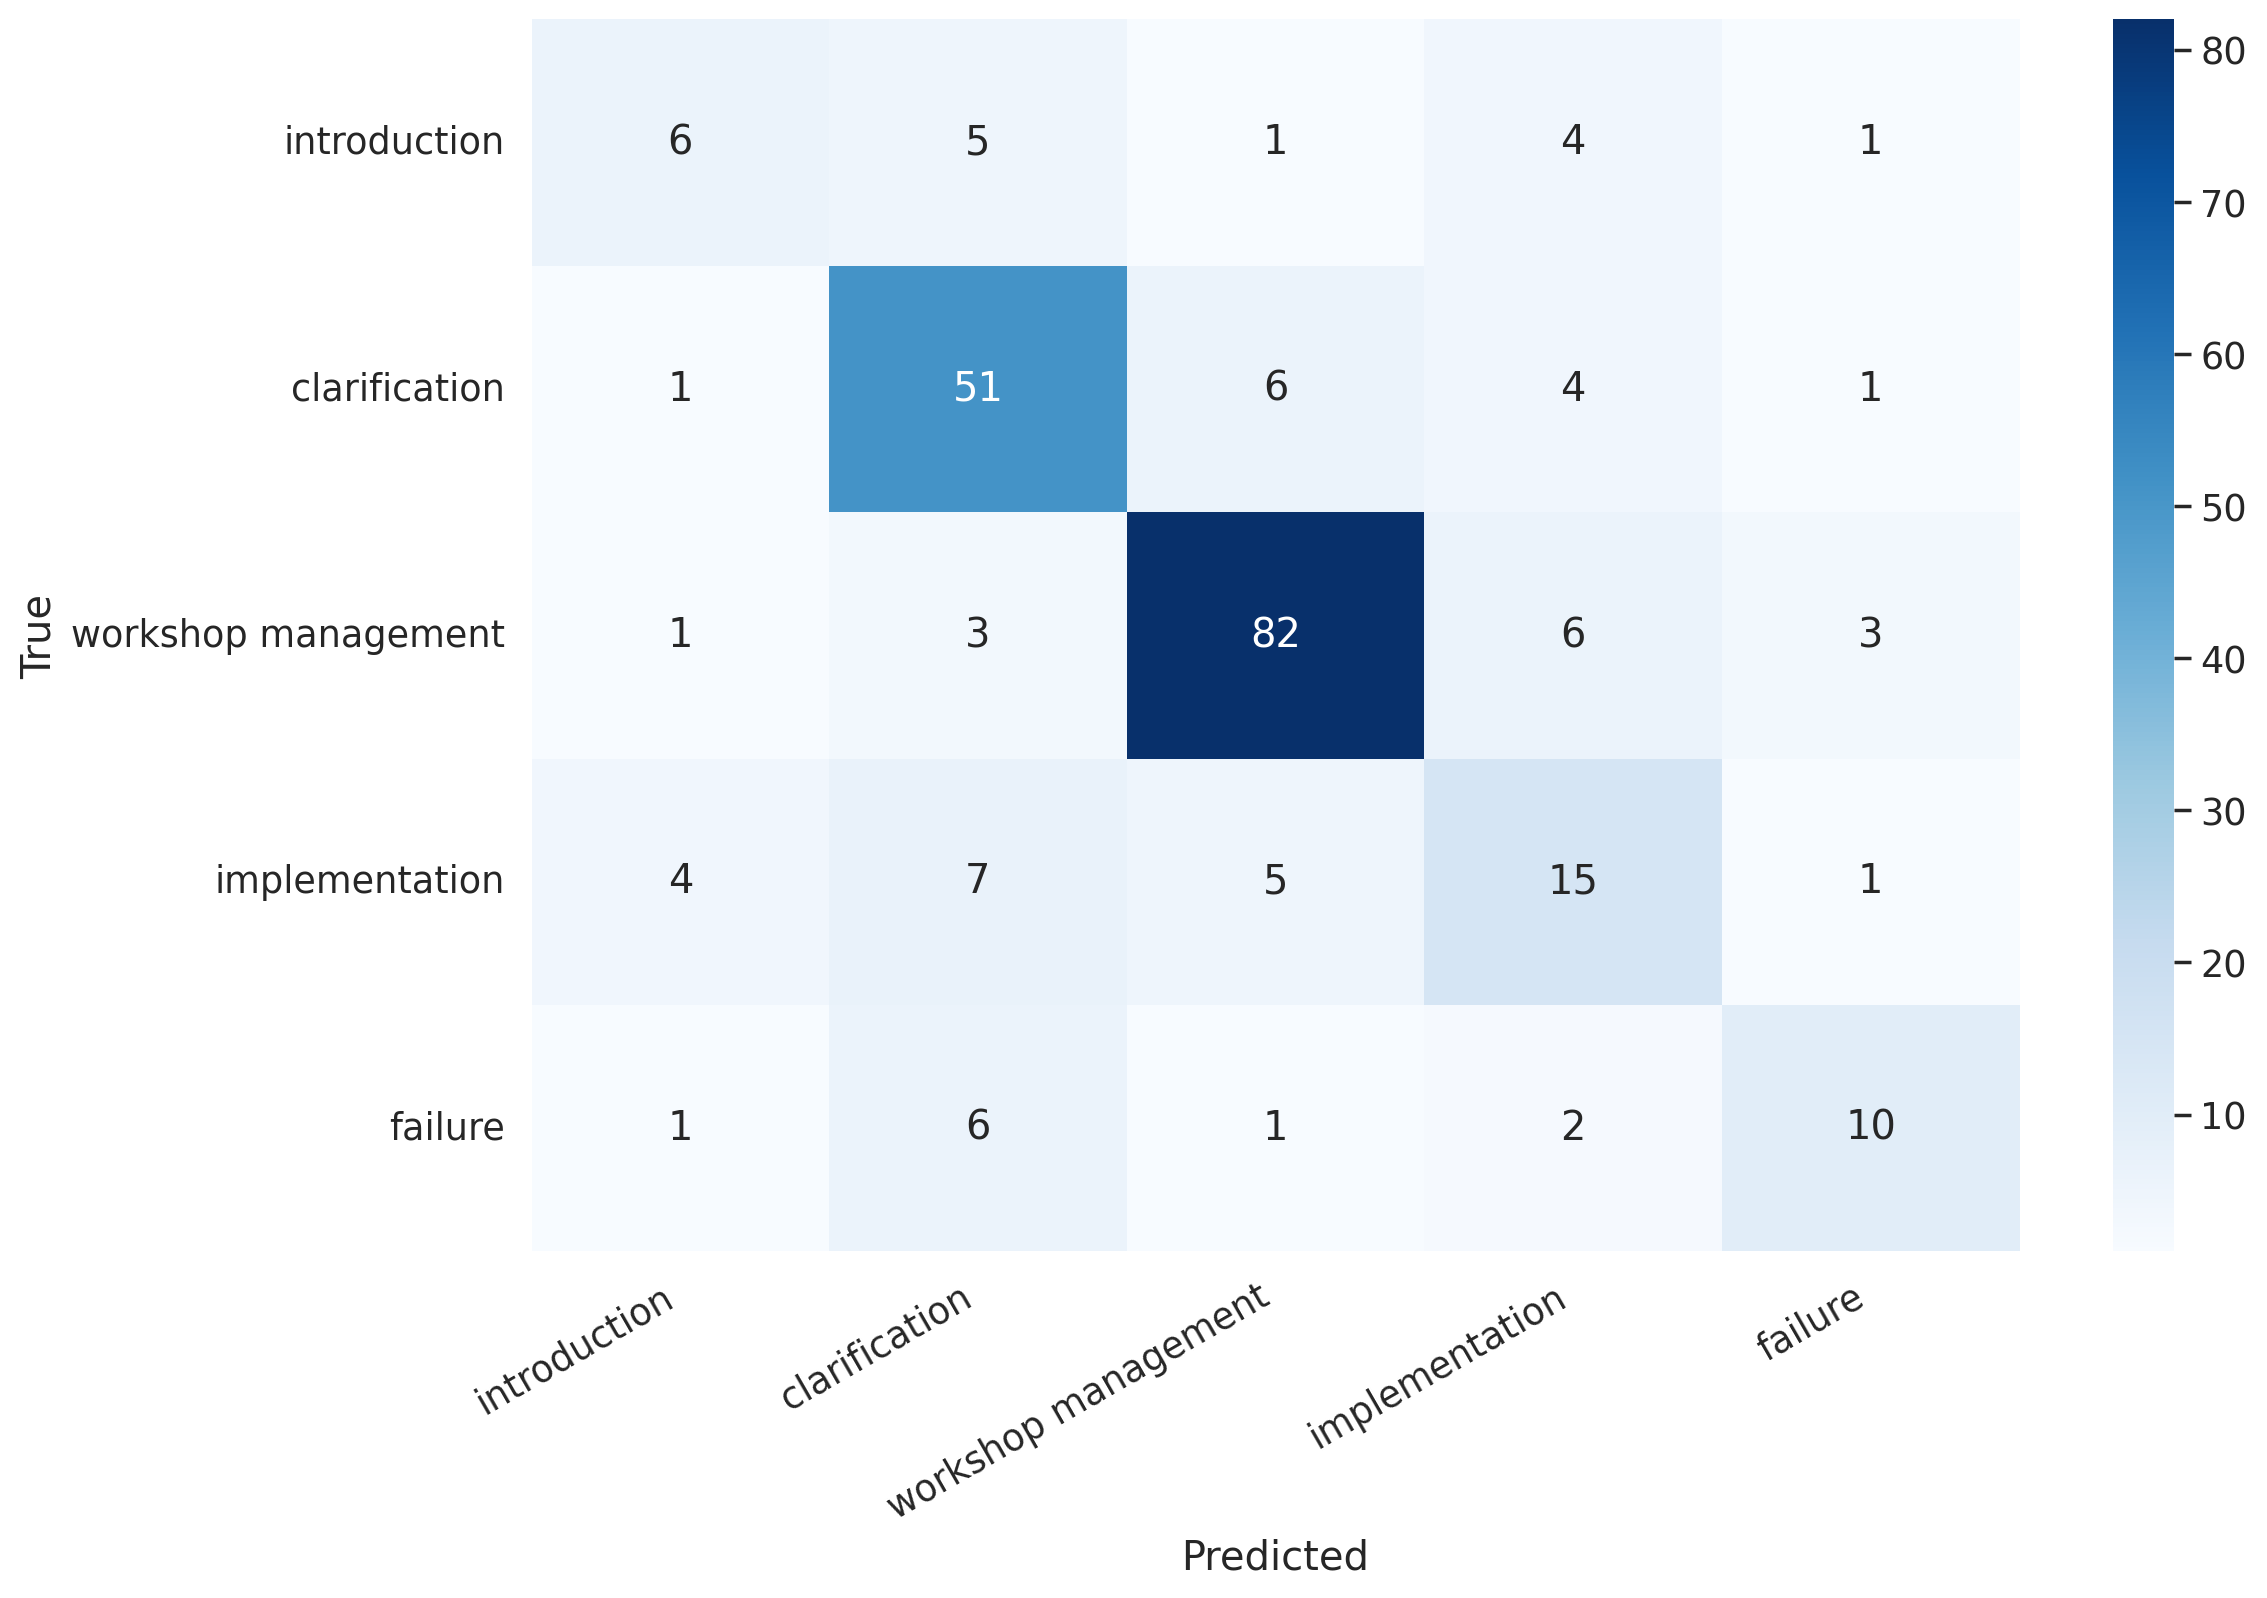

In [18]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [19]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.46      0.35      0.40        17
      clarification       0.71      0.81      0.76        63
workshop management       0.86      0.86      0.86        95
     implementation       0.48      0.47      0.48        32
            failure       0.62      0.50      0.56        20

           accuracy                           0.72       227
          macro avg       0.63      0.60      0.61       227
       weighted avg       0.72      0.72      0.72       227



# Participant

In [20]:
train_dataloader = create_multi_loader(train_p, train_img_p, shuffle=True)
val_dataloader = create_multi_loader(valid_p, test_img_p ,shuffle=False)
test_dataloader = create_multi_loader(test_p, test_img_p ,shuffle=False)

In [21]:
model=AudioTextModel(5).to(device)
params = [
    {"params": model.text_model.parameters(), "lr": bert_lr},
    {"params": model.audio_premodel.parameters(), "lr": res_lr} ]
optimizer = torch.optim.AdamW(params=params, weight_decay=0.)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode="min", patience=patience, factor=factor)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
for e in range(epoch):

    print(f'Epoch {e + 1}/{epoch}')
    print('-' * 10)
    train_acc, train_loss= train_epoch(model,
                                       train_dataloader,
                                       optimizer,
                                       n_train_p)

    print(f'Train loss {train_loss} accuracy {train_acc}')
    with torch.no_grad():
        val_acc ,val_loss= eval_model(model,val_dataloader, n_valid_p)


    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/P_multi_encoder.pt')

Epoch 1/20
----------


100%|██████████| 91/91 [15:18<00:00, 10.09s/it, train_loss=1.4]


Train loss 1.5026226908296019 accuracy 0.32160110420979987


100%|██████████| 12/12 [01:51<00:00,  9.27s/it, val_loss=1.56]


Val loss 0.09675334246603998 accuracy 0.34065934065934067

Epoch 2/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.40it/s, train_loss=1.53]


Train loss 1.3256846417437542 accuracy 0.46031746031746035


100%|██████████| 12/12 [00:01<00:00,  9.43it/s, val_loss=1.79]


Val loss 0.09534747652955107 accuracy 0.45604395604395603

Epoch 3/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.38it/s, train_loss=0.71]


Train loss 1.0242678739212372 accuracy 0.6045548654244306


100%|██████████| 12/12 [00:01<00:00,  9.47it/s, val_loss=1.65]


Val loss 0.09081647618786319 accuracy 0.4945054945054945

Epoch 4/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.40it/s, train_loss=0.259]


Train loss 0.6534232199192047 accuracy 0.7777777777777778


100%|██████████| 12/12 [00:01<00:00,  9.65it/s, val_loss=1.81]


Val loss 0.1011327095739134 accuracy 0.4835164835164835

Epoch 5/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.40it/s, train_loss=0.421]


Train loss 0.3500494410048474 accuracy 0.89648033126294


100%|██████████| 12/12 [00:01<00:00,  9.68it/s, val_loss=1.79]


Val loss 0.12009453118502439 accuracy 0.4725274725274725

Epoch 6/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.41it/s, train_loss=0.0814]


Train loss 0.16584250871296768 accuracy 0.9572118702553485


100%|██████████| 12/12 [00:01<00:00,  9.59it/s, val_loss=1.96]


Val loss 0.1443737804234683 accuracy 0.46703296703296704

Epoch 7/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.40it/s, train_loss=0.0115]


Train loss 0.06044288665301852 accuracy 0.9861973775017253


100%|██████████| 12/12 [00:01<00:00,  9.75it/s, val_loss=2.09]


Val loss 0.15657939229692733 accuracy 0.4725274725274725

Epoch 8/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.40it/s, train_loss=0.0121]


Train loss 0.023283333845109076 accuracy 0.9958592132505176


100%|██████████| 12/12 [00:01<00:00,  9.66it/s, val_loss=2.21]


Val loss 0.17160594725346828 accuracy 0.45604395604395603

Epoch 9/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.42it/s, train_loss=0.00836]


Train loss 0.015580011859208672 accuracy 0.9979296066252589


100%|██████████| 12/12 [00:01<00:00,  9.68it/s, val_loss=2.3]


Val loss 0.17485605425887055 accuracy 0.47802197802197804

Epoch 10/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.40it/s, train_loss=0.0081]


Train loss 0.013496223253781324 accuracy 0.9979296066252589


100%|██████████| 12/12 [00:01<00:00,  9.35it/s, val_loss=2.28]


Val loss 0.1761093218247969 accuracy 0.489010989010989

Epoch 11/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.38it/s, train_loss=0.00569]


Train loss 0.011049432388332846 accuracy 0.9979296066252589


100%|██████████| 12/12 [00:01<00:00,  9.55it/s, val_loss=2.31]


Val loss 0.1778395143184033 accuracy 0.4835164835164835

Epoch 12/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.41it/s, train_loss=0.00558]


Train loss 0.00920471930774031 accuracy 0.9993098688750863


100%|██████████| 12/12 [00:01<00:00,  9.27it/s, val_loss=2.34]


Val loss 0.18260017332139905 accuracy 0.47802197802197804

Epoch 13/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.39it/s, train_loss=0.00563]


Train loss 0.007951425454978431 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  9.67it/s, val_loss=2.41]


Val loss 0.18500166410928245 accuracy 0.4725274725274725

Epoch 14/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.41it/s, train_loss=0.00798]


Train loss 0.007585045635945849 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  9.46it/s, val_loss=2.41]


Val loss 0.1841646052978851 accuracy 0.47802197802197804

Epoch 15/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.40it/s, train_loss=0.00596]


Train loss 0.007470666287610164 accuracy 0.9993098688750863


100%|██████████| 12/12 [00:01<00:00,  9.73it/s, val_loss=2.38]


Val loss 0.18908258584829477 accuracy 0.46703296703296704

Epoch 16/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.41it/s, train_loss=0.00649]


Train loss 0.0075230363162828015 accuracy 0.9993098688750863


100%|██████████| 12/12 [00:01<00:00,  9.52it/s, val_loss=2.32]


Val loss 0.1865980441753681 accuracy 0.47802197802197804

Epoch 17/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.41it/s, train_loss=0.00811]


Train loss 0.007744656369131017 accuracy 0.9986197377501725


100%|██████████| 12/12 [00:01<00:00,  9.68it/s, val_loss=2.33]


Val loss 0.18725186258881957 accuracy 0.47802197802197804

Epoch 18/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.39it/s, train_loss=0.00586]


Train loss 0.007420229720422528 accuracy 0.9993098688750863


100%|██████████| 12/12 [00:01<00:00,  9.60it/s, val_loss=2.36]


Val loss 0.18742024767529833 accuracy 0.47802197802197804

Epoch 19/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.40it/s, train_loss=0.00638]


Train loss 0.007272440187919598 accuracy 0.9993098688750863


100%|██████████| 12/12 [00:01<00:00,  9.64it/s, val_loss=2.36]


Val loss 0.18758541149097485 accuracy 0.47802197802197804

Epoch 20/20
----------


100%|██████████| 91/91 [00:26<00:00,  3.40it/s, train_loss=0.00626]


Train loss 0.007271766181584898 accuracy 0.9993098688750863


100%|██████████| 12/12 [00:01<00:00,  9.17it/s, val_loss=2.33]


Val loss 0.18950543167826894 accuracy 0.4725274725274725



In [23]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader)

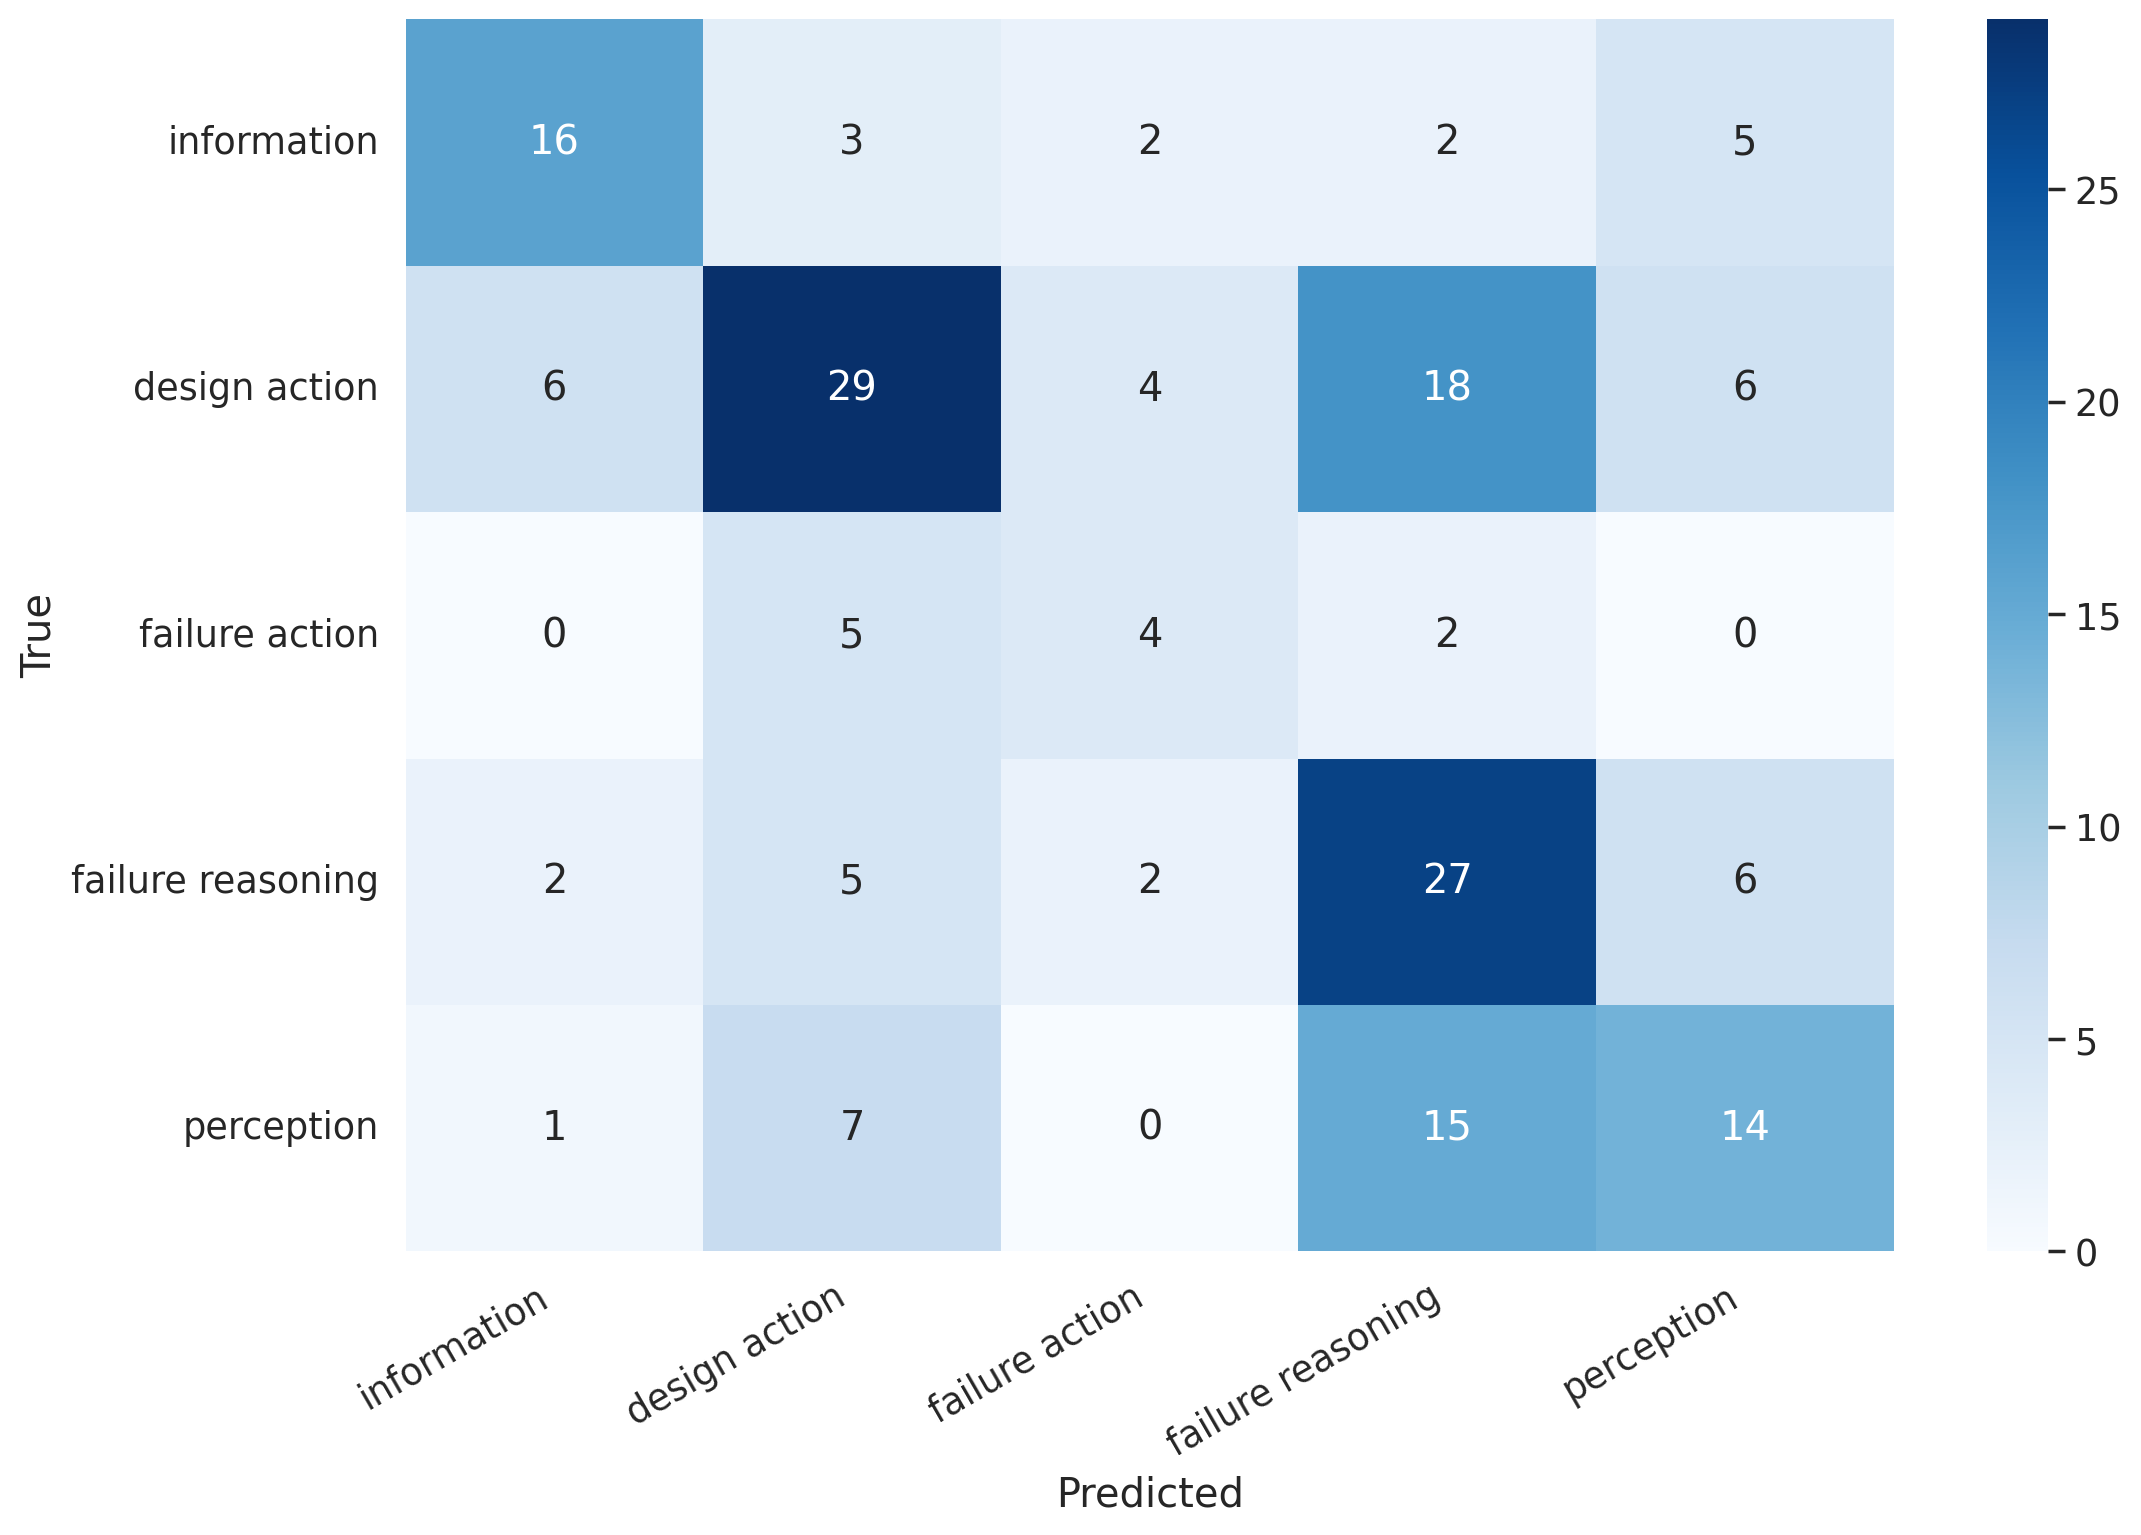

In [24]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [25]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.64      0.57      0.60        28
    design action       0.59      0.46      0.52        63
   failure action       0.33      0.36      0.35        11
failure reasoning       0.42      0.64      0.51        42
       perception       0.45      0.38      0.41        37

         accuracy                           0.50       181
        macro avg       0.49      0.48      0.48       181
     weighted avg       0.52      0.50      0.50       181

